<a href="https://colab.research.google.com/github/levutb2004/deep_learning_uet/blob/main/BBC_Text_Classification_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries

In [1]:
!wget -O /content/sample_data/bbc-text.csv https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/master/bbc-text.csv

--2024-12-08 03:50:27--  https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5059719 (4.8M) [text/plain]
Saving to: ‘/content/sample_data/bbc-text.csv’

/content/sample_dat 100%[===================>]   4.83M  --.-KB/s    in 0.07s   

2024-12-08 03:50:28 (73.2 MB/s) - ‘/content/sample_data/bbc-text.csv’ saved [5059719/5059719]



In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
import tqdm
import seaborn as sns
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from warnings import filterwarnings
from tensorflow.keras.utils import to_categorical
import nltk
from tensorflow.python.client import device_lib
from nltk.corpus import stopwords
nltk.download('stopwords')
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3529604761016874948
 xla_global_id: -1]

In [4]:
df = pd.read_csv('/content/sample_data/bbc-text.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [5]:
df.isna().sum()

,0
category,0
text,0


In [6]:
df['text'] = df['text'].str.lower()

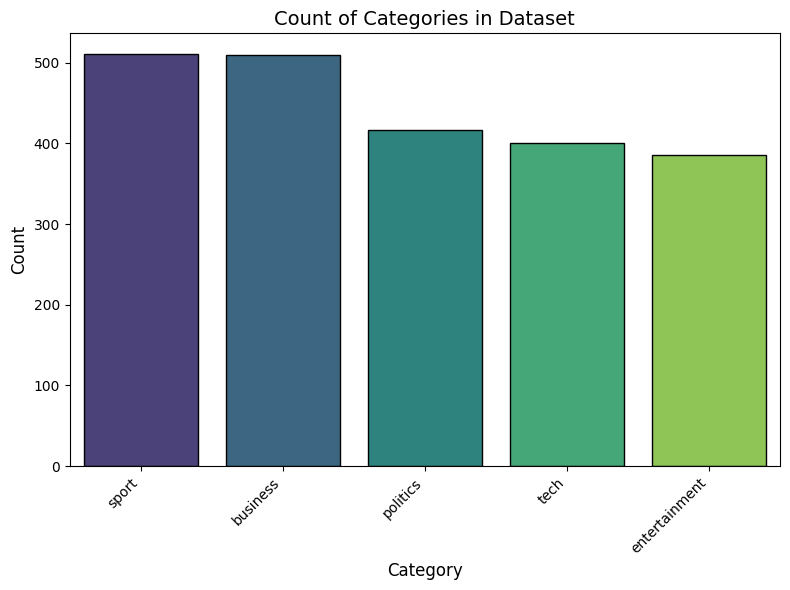

In [8]:
# Count of categories
category_counts = df['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of Categories in Dataset", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
# train_test_split
x_train, x_test = train_test_split(df, random_state=1, test_size=0.2)
x_train.shape, x_test.shape

((1780, 2), (445, 2))

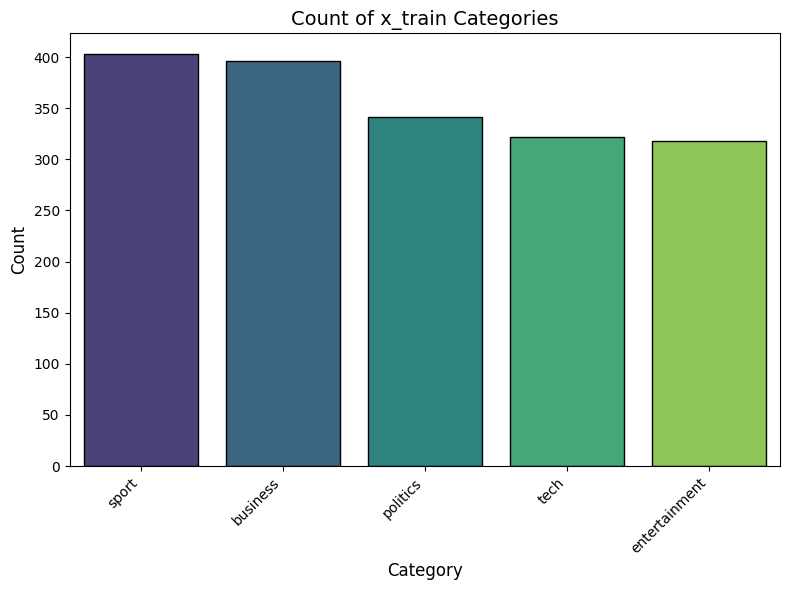

In [12]:
# Count of categories
category_counts = x_train['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of x_train Categories", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

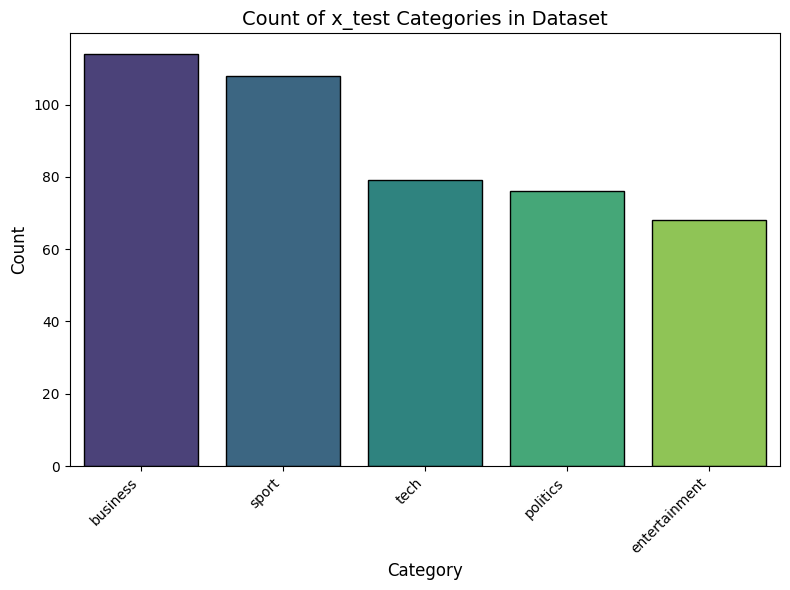

In [13]:
# Count of categories
category_counts = x_test['category'].value_counts()

# Plot the count of categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", edgecolor="black")
plt.title("Count of x_test Categories in Dataset", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [14]:
x_train['category']


,category
331,tech
190,politics
309,politics
1226,sport
1364,tech
...,...
960,business
905,entertainment
1096,tech
235,business


In [15]:
y_test = x_test['category']
x_test = x_test['text']

In [17]:
y_train = x_train['category']
x_train = x_train['text']

In [18]:
y_train

,category
331,tech
190,politics
309,politics
1226,sport
1364,tech
...,...
960,business
905,entertainment
1096,tech
235,business


In [19]:
def remove_punch(data):
    cleaned_data = []
    for sentences in data:
        new_sentence = sentences.translate(str.maketrans('','',string.punctuation))
        new_sentence = re.sub(r"[\n\t]*", "", new_sentence)
        new_sentence = re.sub('  ', "", new_sentence)

        cleaned_data.append(new_sentence)
    return np.array(cleaned_data)

In [20]:
removed_punch_x_train = remove_punch(x_train)
x_train.shape, removed_punch_x_train.shape

((1780,), (1780,))

In [21]:
removed_punch_x_test = remove_punch(x_test)
x_test.shape, removed_punch_x_test.shape

((445,), (445,))

In [22]:
x_test

,text
1664,blues slam blackburn over savage birmingham ha...
1347,mps tout lords replacement plan a group of mps...
432,england 17-18 france england suffered an eight...
1435,banker loses sexism claim a former executive a...
1374,eu software patent law faces axe the european ...
...,...
1060,apple ipod family expands market apple has exp...
464,metlife buys up citigroup insurer us banking g...
1494,brit awards for devon music acts devon singer ...
2058,new media battle for bafta awards the bbc lead...


In [23]:
x_test[1664][:350], '........................',removed_punch_x_test[0][:350]

('blues slam blackburn over savage birmingham have confirmed blackburn made a bid for robbie savage - but managing director karen brady has called it  derisory .  rovers have reportedly offered £500 000 up front for the wales star  30  with the fee rising to £2.2m. but brady told the sun the bid was  a waste of fax paper and my time . she added:  the',
 '........................',
 'blues slam blackburn over savage birmingham have confirmed blackburn made a bid for robbie savagebut managing director karen brady has called itderisory rovers have reportedly offered £500 000 up front for the wales star30with the fee rising to £22m but brady told the sun the bid wasa waste of fax paper and my timeshe addedthe way things are going ')

In [24]:
print(f'train: {removed_punch_x_train.shape},\ntest:, {removed_punch_x_test.shape}')

train: (1780,),
test:, (445,)


In [25]:
def text_vizual(category,data_train):
    text = ''
    for txt in tqdm.tqdm(data_train[y_train==f'{category}']):
        text +=txt
    wordcloud_spam = WordCloud(background_color="white").generate(text)
    # Lines 2 - 5
    plt.figure(figsize = (15,15))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'The most used words of category {category}')
    plt.show()

100%|██████████| 322/322 [00:00<00:00, 8500.92it/s]


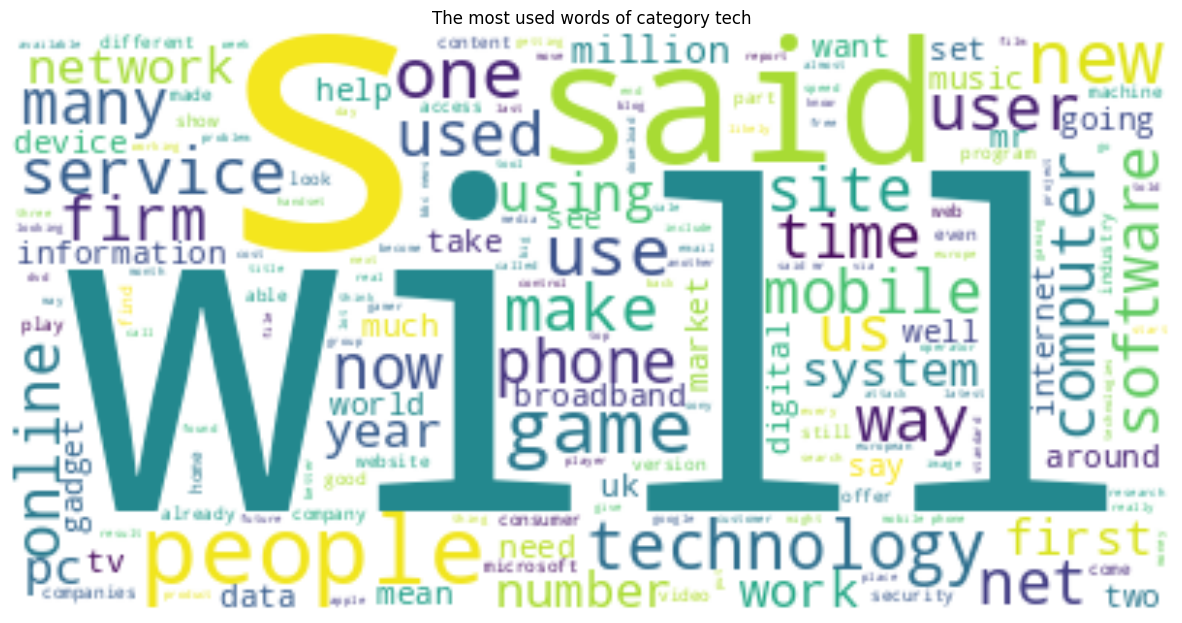

In [26]:
text_vizual('tech', removed_punch_x_train)

100%|██████████| 396/396 [00:00<00:00, 9803.13it/s]


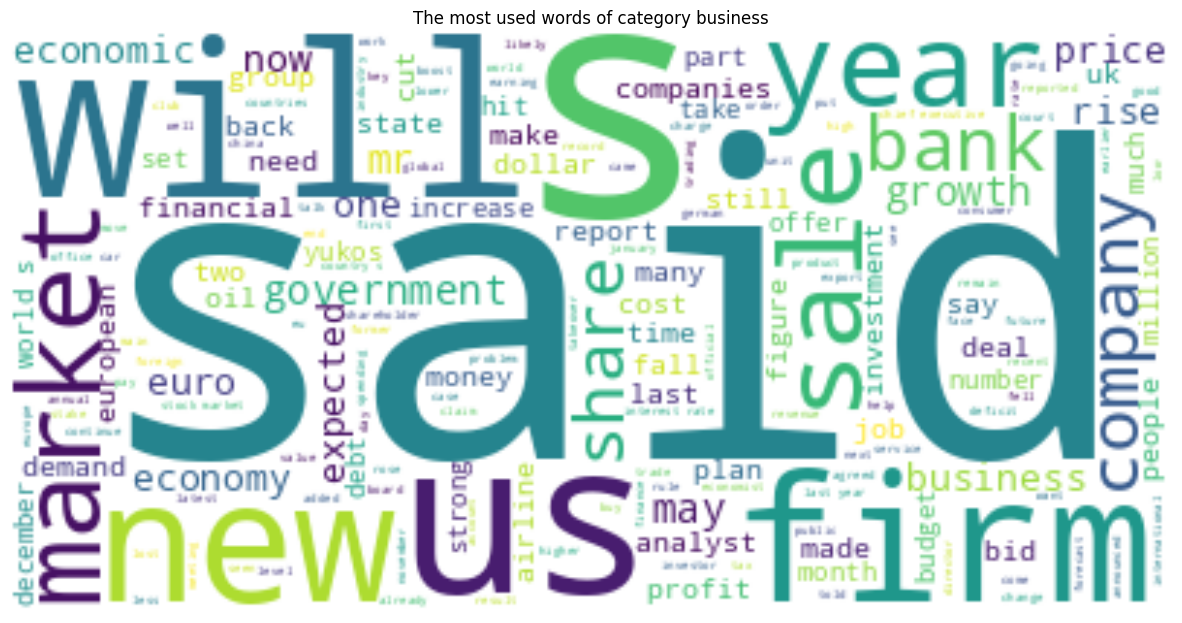

In [27]:
text_vizual('business', removed_punch_x_train)

## removing stop words

In [30]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [28]:
def remove_stop_words(data):
    cleaned_data = []
    for sentences in data:
        tokenized = word_tokenize(sentences, 'english')
        new_sentence =  [token for token in tokenized  if token not in  stopwords.words('english')]
        sent = ''
        for text in new_sentence:
            sent+=text + ' '
        cleaned_data.append(sent)
    return np.array(cleaned_data)

In [31]:
cleaned_x_train = remove_stop_words(removed_punch_x_train)

In [32]:
cleaned_x_test = remove_stop_words(removed_punch_x_test)

In [33]:
cleaned_x_train.shape, cleaned_x_test.shape

((1780,), (445,))

## vizualizing cleaned text

100%|██████████| 322/322 [00:00<00:00, 12798.78it/s]


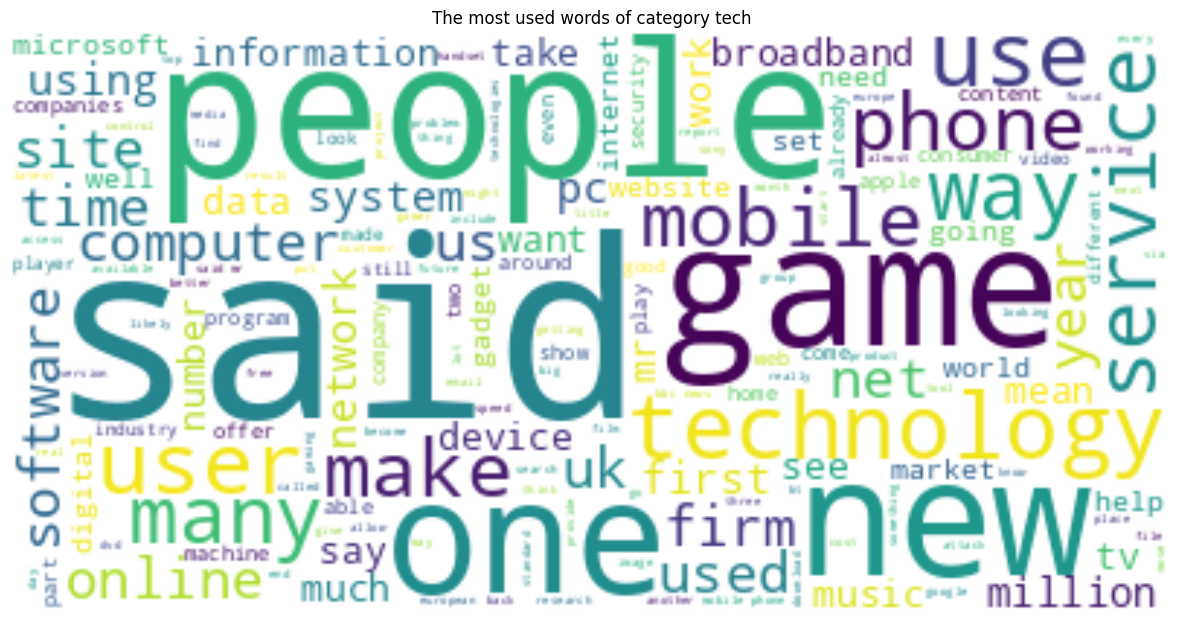

In [34]:
text_vizual('tech', cleaned_x_train)

## before removing stopwords

100%|██████████| 322/322 [00:00<00:00, 7043.81it/s]


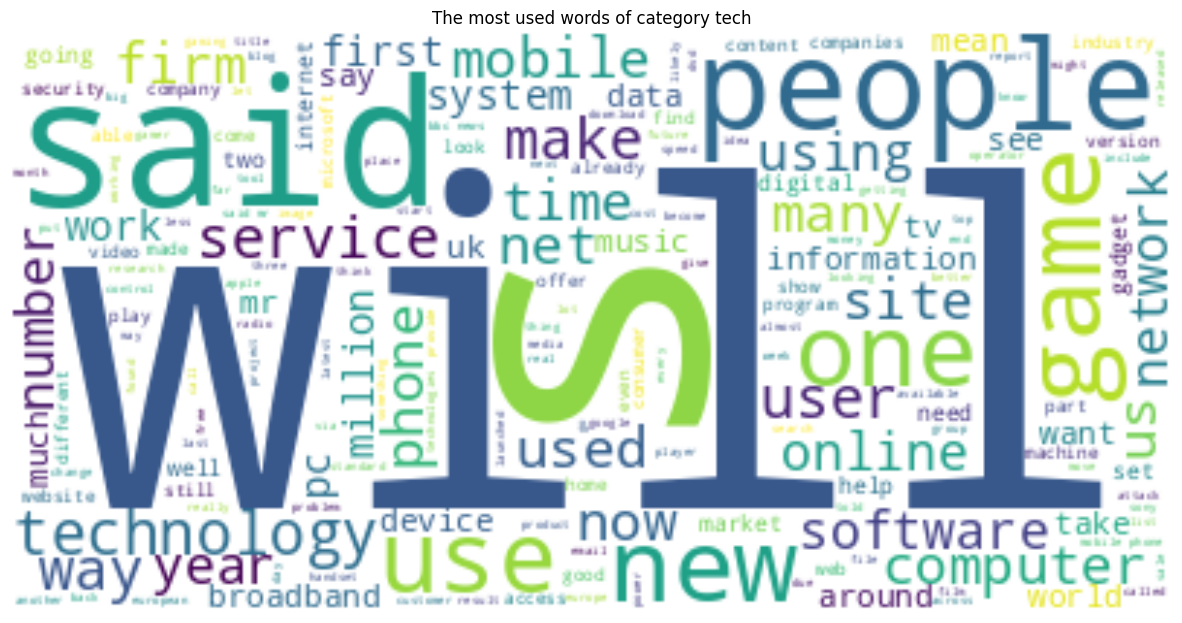

In [35]:
text_vizual('tech', removed_punch_x_train)

## label encode target features

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [38]:
le.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [40]:
y_train = le.transform(y_train)
y_test =  le.transform(y_test)

In [41]:
y_train = to_categorical(y_train,5)
y_test = to_categorical(y_test,5)

## Tokenize

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
tokenizer = Tokenizer()

In [45]:
allDocs = list(cleaned_x_train) + list(cleaned_x_test)
tokenizer.fit_on_texts(allDocs)

In [46]:
tokenizer.document_count

2225

In [47]:
document_count = tokenizer.document_count
vocab_size = len(tokenizer.word_index)
print(f'document_count: {document_count}\nvocab_size: {vocab_size}')

document_count: 2225
vocab_size: 70804


In [48]:
allDocs_sequence = tokenizer.texts_to_sequences(allDocs)
max_length = max([ len(x) for x in allDocs_sequence])
max_length

2165

In [49]:
train_sequences = tokenizer.texts_to_sequences(list(cleaned_x_train))
test_sequences = tokenizer.texts_to_sequences(list(cleaned_x_test))

In [50]:
# pad the sequences
train_padded = pad_sequences(train_sequences,padding='post', truncating = 'post', maxlen = max_length )
test_padded = pad_sequences(test_sequences,padding='post', truncating = 'post', maxlen = max_length )

In [51]:
train_padded.shape

(1780, 2165)

In [52]:
train_padded

array([[ 4761, 12364,   643, ...,     0,     0,     0],
       [ 4107,  5016,  1231, ...,     0,     0,     0],
       [  566,  1290,   523, ...,     0,     0,     0],
       ...,
       [  198,  3247,  5034, ...,     0,     0,     0],
       [  348,   261,  4219, ...,     0,     0,     0],
       [ 1203,  5575,   284, ...,     0,     0,     0]], dtype=int32)

In [53]:
test_padded.shape

(445, 2165)

In [54]:
train_padded

array([[ 4761, 12364,   643, ...,     0,     0,     0],
       [ 4107,  5016,  1231, ...,     0,     0,     0],
       [  566,  1290,   523, ...,     0,     0,     0],
       ...,
       [  198,  3247,  5034, ...,     0,     0,     0],
       [  348,   261,  4219, ...,     0,     0,     0],
       [ 1203,  5575,   284, ...,     0,     0,     0]], dtype=int32)

In [55]:
train_padded.shape

(1780, 2165)

## Model

In [56]:
class Model(tf.keras.Model):
    def __init__(self, num_classes, shape):
        super().__init__()
        self.embedding = Embedding(vocab_size+1,num_classes, input_length=  max_length, name = 'embedded')
        self.lstm = LSTM(20,activation=tf.nn.tanh, return_sequences=True)
        self.flatten = Flatten()
        self.dense1 = Dense(32, activation='relu')
        self.output_dense = Dense(num_classes, activation= 'softmax')
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.output_dense(x)
model = Model(len(df['category'].unique()), train_padded.shape)

In [60]:
model.compile(optimizer='adam',metrics = ['accuracy'], loss = tf.keras.losses.CategoricalCrossentropy())

In [61]:
history  = model.fit(train_padded, y_train, epochs = 5)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2409 - loss: 1.6101
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4704 - loss: 1.2135
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8727 - loss: 0.4303
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9461 - loss: 0.1447
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9959 - loss: 0.0132


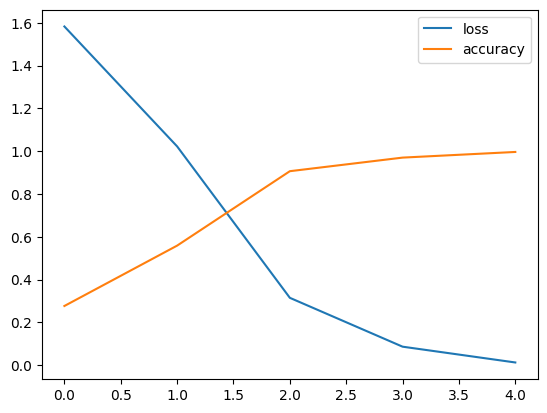

In [62]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

In [63]:
test_pred = model.predict(test_padded, verbose = 1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step


In [64]:
test_pred.argmax(axis=1)

array([1, 2, 3, 2, 0, 1, 0, 3, 1, 4, 1, 2, 0, 4, 2, 2, 0, 4, 0, 1, 0, 0,
       0, 2, 1, 4, 3, 4, 3, 4, 0, 3, 1, 3, 0, 4, 3, 0, 2, 0, 4, 0, 0, 4,
       4, 0, 0, 1, 0, 4, 3, 3, 1, 3, 4, 3, 0, 1, 3, 0, 1, 0, 3, 3, 3, 4,
       0, 2, 3, 2, 0, 2, 0, 4, 0, 4, 4, 2, 3, 0, 0, 4, 1, 4, 2, 1, 0, 1,
       3, 1, 0, 2, 4, 3, 3, 0, 4, 3, 3, 3, 4, 0, 3, 2, 0, 1, 1, 0, 0, 1,
       1, 4, 2, 2, 1, 3, 3, 0, 3, 4, 1, 3, 0, 0, 4, 4, 3, 2, 3, 1, 0, 3,
       0, 4, 0, 2, 1, 2, 1, 0, 0, 3, 0, 2, 4, 2, 0, 3, 4, 2, 2, 3, 2, 0,
       4, 0, 3, 4, 2, 0, 3, 3, 3, 3, 4, 3, 2, 4, 4, 2, 0, 1, 4, 3, 4, 0,
       3, 0, 1, 0, 3, 4, 1, 1, 2, 0, 0, 2, 1, 3, 3, 4, 0, 1, 3, 1, 1, 3,
       2, 2, 1, 1, 2, 4, 1, 4, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 2, 1,
       0, 2, 1, 3, 1, 3, 3, 4, 4, 2, 1, 2, 0, 3, 3, 1, 2, 1, 0, 0, 0, 0,
       2, 4, 3, 0, 2, 3, 3, 3, 3, 2, 3, 0, 1, 3, 3, 4, 4, 3, 0, 2, 3, 3,
       4, 2, 3, 2, 2, 3, 1, 1, 0, 4, 1, 0, 0, 3, 0, 3, 3, 3, 0, 3, 2, 4,
       3, 3, 2, 3, 4, 2, 0, 3, 0, 3, 0, 2, 4, 0, 4,

In [65]:
print(classification_report(y_test.argmax(axis=1), test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       114
           1       0.91      0.94      0.93        68
           2       0.96      0.92      0.94        76
           3       0.98      0.97      0.98       108
           4       0.90      0.95      0.93        79

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



In [66]:
test_padded

array([[ 2544,  1166,  3092, ...,     0,     0,     0],
       [  517, 24080,   889, ...,     0,     0,     0],
       [   64, 62358,   259, ...,     0,     0,     0],
       ...,
       [ 2967,   282,  5319, ...,     0,     0,     0],
       [    5,   190,   715, ...,     0,     0,     0],
       [  243, 19208,  2652, ...,     0,     0,     0]], dtype=int32)

In [67]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [68]:
le.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [69]:
rnd = np.random.randint(0, len(test_padded))
test_single_data = test_padded[rnd]
y_single_data = y_test[rnd]
print(test_single_data)
print("*"*50)
print(y_single_data)
print(f'real_class: {le.classes_[y_single_data.reshape(1,-1).argmax(axis=1)[0]]}')
print(f'class_index: {y_single_data.reshape(1,-1).argmax(axis=1)[0]}')

[63272    74 63273 ...     0     0     0]
**************************************************
[1. 0. 0. 0. 0.]
real_class: business
class_index: 0


In [70]:
test_single_data_reshaped = test_single_data.reshape(1,2165)

In [71]:
single_predicted = model.predict(test_single_data_reshaped, verbose= 1)
single_predicted.argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


array([0])

**sport = 3 true prediction**

In [74]:
model.save("/content/sample_data/text_categorization_model.h5", save_format='tf')